In [1]:
%matplotlib inline

import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt

import sys
sys.path.append('../code')
import gpr as gp
import kernel as ks

from scipy.spatial.distance import squareform, pdist, cdist

/Users/skachuck/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Linear Regression as Gaussian Process

This material is taken (some of it verbatim) from the book <a href='http://www.gaussianprocess.org/gpml/chapters/'>_Gaussian Processes for Machine Learning_ by Rasmussen and Williams (2006)</a> (you can download chapters or the entire book by following the link).

**Definition 2.1** _A_ Gaussian process _is a collection of random variables, any finite number of which have a joint Gaussian distribution._

For a function (real process) $f(\mathbf{x})$, with expectation (mean) $m(\mathbf{x})$ and covariance function 
$$k(\mathbf{x},\mathbf{x}') = \mathbb{E}\left[(f(\mathbf{x}) - m(\mathbf{x}))(f(\mathbf{x}') - m(\mathbf{x}')\right]$$
we can write the Gaussian Process
$$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x},\mathbf{x}')).$$

Practically speaking, this means that if we believe our data has been drawn from a function 

Before jumping in with data, let's generate a prior on the function. We'll aim to recreate the function $f$ at 50 points, arranged into the matrix $X_*$ (in our 1D example, the matrix $X_*$ has size $1\times 50$, but the method generalizes to multiple dimensions). We will imagine our function $f$ has zero mean $m(\mathbf{x})=\mathbf{0}$ and it's covariance is the _squared exponential_ (Gaussian, rbf, ...so many names).
$$k(\mathbf{x},\mathbf{x}') = \exp\left(-\frac{1}{2}\|\mathbf{x} - \mathbf{x}'\|^2\right).$$
Now we can generate the covariance matrix (size $50\times50$) between our sampling points $K(X_*, X_*)$ whose $ij$th element is $k(\mathbf{x_i},\mathbf{x_j})$. Thus we can sample potential function values evaluated at $X_*$, $f_* = f(X_*)$, since
$$ f_* \sim \mathcal{N}(\mathbf{0}, K(X_*, X_*)),$$
as shown just below.

In [9]:
x_test = np.linspace(-5, 5)

k = lambda u, v: np.exp(-0.5*(u-v)**2)
K_test = squareform(pdist(x_test[:, None], k)) + (1+1E-14)*np.eye(len(x_test))
f_prior = np.random.multivariate_normal(np.zeros_like(x_test), K_test, 3)

We add a tiny identity matrix $\mathbb{1}$ to K to improve numerical stability. See Rasmussen A.2

All the same, the sampling has worked and we can view a few of these test functions below and the 95% confidence range for output values.

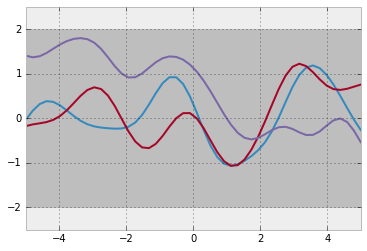

In [10]:
for line in f_prior:
    plt.plot(x_test, line)
plt.fill_between(x_test, -2, 2, color='k', alpha=0.2);
plt.xlim([-5, 5]); plt.ylim([-2.5, 2.5]);

Note how smooth these appear. In fact, the squared exponential covariance function is infinitely differentiable, leading to a process that is infinitely mean-square differentiable (don't know what this means; see, apparently section 4.1). The functions have a characteristic length of about 1 unit, which comes directly from the squared exponential covariance.

## Prediction with Noise-free Observations

Imagine that we are now able to perfectly test our function at five random locations $X$ (shown below)

In [11]:
x_obs = np.random.choice(x_test, 5)

K_obs = squareform(pdist(x_obs[:, None], k)) + (1+1E-14)*np.eye(len(x_obs))
y_obs = np.random.multivariate_normal(np.zeros_like(x_obs), K_obs)

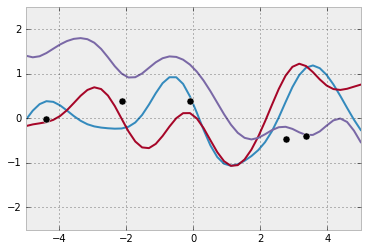

In [12]:
for line in f_prior:
    plt.plot(x_test, line)
plt.scatter(x_obs, y_obs, c='k', s=50, zorder=100)
plt.xlim([-5, 5]); plt.ylim([-2.5, 2.5]);

We could, in priciple, sample our prior distribution and reject any distribution that doesn't go through our measured points exactly, but we have a much better way! Since $f(\mathbf{x})$ is a Gaussian Process, we know that the values $f = f(X)$ and the wanted values $f_*$ have a joint distribution
$$\left[ \begin{matrix}f \\ f_*\end{matrix}\right] \sim \mathcal{N}\left(\mathbf{0}, \left[ \begin{matrix}K(X,X) & K(X,X_*)\\ K(X_*,X) & K(X_*,X_*) \end{matrix}\right]\right).$$

This allows us to discover the posterior probability distribution of $f_*$ given a certain draw of $f$ as
$$f_* | X_*, X, f \sim \mathcal(K(X_*,X)K(X,X)^{-1}f, K(X_*, X_*) - K(X_*, X)K(X,X)^{-1}K(X,X_*))$$
via some fancy properties of joint Gaussian distributions.

We therefore have all we need to make some draws from this posterior distribution of desired function values, as shown below.


In [13]:
k = lambda x1, x2: np.exp(-0.5 * (x1-x2).dot(x1-x2))
K_obs_test = cdist(x_test[:,None], x_obs[:,None], k)

Kinv = np.linalg.inv(K_obs)
f_post_mean = K_obs_test.dot(Kinv.dot(y_obs))
f_post_cov = K_test - K_obs_test.dot(Kinv.dot(K_obs_test.T))

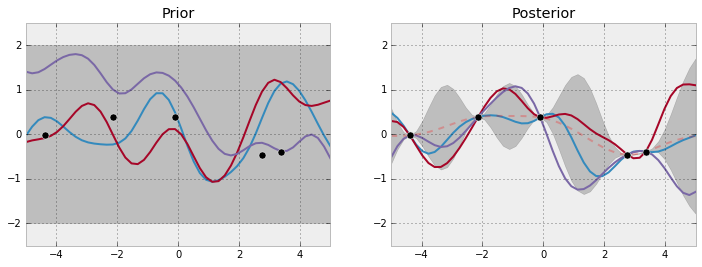

In [14]:
f_conditioned = np.random.multivariate_normal(f_post_mean, f_post_cov, 3)

fig, axs = plt.subplots(1,2, figsize=(12,4))

for line in f_prior:
    axs[0].plot(x_test, line)
axs[0].fill_between(x_test, -2, 2, color='k', alpha=0.2);
axs[0].scatter(x_obs, y_obs, c='k', s=50, zorder=100)
axs[0].set_xlim([-5, 5]); axs[0].set_ylim([-2.5, 2.5]); axs[0].set_title('Prior');

for line in f_conditioned:
    axs[1].plot(x_test, line)

post_stds = f_post_cov.diagonal()#np.sqrt(np.maximum(1e-12, f_post_cov.diagonal()))
axs[1].fill_between(x_test, f_post_mean + 2*post_stds, 
                            f_post_mean - 2*post_stds, color='k', alpha=0.2)
axs[1].plot(x_test, f_post_mean, c='r', ls='--', alpha=0.25)
axs[1].scatter(x_obs, y_obs, c='k', s=50, zorder=100)
axs[1].set_xlim([-5, 5]); axs[1].set_ylim([-2.5, 2.5]); axs[1].set_title('Posterior');

If there is some noise in our function, such that our observations are actually $y=f(\mathbf{x}) + \epsilon$, where $\epsilon\sim \mathcal{N}(0, \sigma_n^2)$, then the prior on the noisy observations becomes
$$\textrm{cov}(y_p, y_q) = k(\mathbf{x}_p, \mathbf{x}_q) + \sigma_n^2\delta_{pq}$$
or $\textrm{cov}(\mathbf{y}) = K(X,X) + \sigma_n^2I$, and the calculation proceeds exactly as before.

We summarie this process into the following algorithm.

## The Algorithm

In [25]:
def gp_regression(x_obs, y_obs, k, sigsq_noise, x_test):
    """Predictions and log marginal likelihood for Gaussian process regression.
    
    The implentation addresses the matrix inversion required using Cholesky 
    factorization. The log determinant required for the log marginal likelihood
    is computed from the Cholesky factor (for large n it may not be possible to 
    represent the determinant itself). The computational complexity is n^3/6 for
    the Cholesky decomposition and n^2/2 for solving the triangular systems.
    
    Inputs
    ------
    x_obs       : (nobs, ndim)
    y_obs       : (nobs)
    k           : covariance function
    siqsq_noise : float (noise of observations)
    x_test      : (npred, ndim)
        The inputs at which predictions are desired.
    """
    
    n = len(x_obs.T)
    K_obs = k(x_obs, x_obs)
    K_obs_test = k(x_obs, x_test)
    
    L = spl.cho_factor(K_obs + sigsq_noise * np.eye(n))
    
    alpha = spl.cho_solve(L, y_obs)
    y_test_mean = K_obs_test.T.dot(alpha)
    y_test_var = (k(x_test, x_test) - 
                  K_obs_test.T.dot(spl.cho_solve(L, K_obs_test)))
    
    # Log marginal likelihood.
    logmarg = -0.5*y_obs.dot(alpha) - np.sum(L[0].diagonal()) - 0.5*n*np.log(2*np.pi)
    
    return y_test_mean, y_test_var, logmarg

In [26]:
def sq_exp_cov(x1, x2, l=1, sigsqf=1):
    k = lambda u, v: sigsqf*np.exp(-0.5*(u-v).dot(u-v)/l**2)
    return cdist(x1[:,None], x2[:,None], k)

In [27]:
y_test_mean, y_test_var, logmarg = gp_regression(x_obs, y_obs, sq_exp_cov, sigsq_noise=0.1, x_test=x_test)

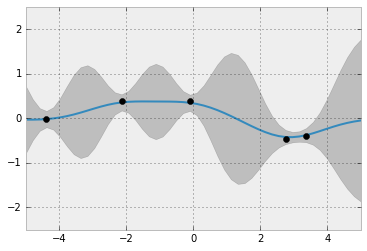

In [28]:
plt.plot(x_test, y_test_mean)
plt.plot(x_obs, y_obs, 'ko')
post_stds = y_test_var.diagonal()
plt.fill_between(x_test, y_test_mean + 2*post_stds, 
                         y_test_mean - 2*post_stds, 
                 color='k', alpha=0.2)
plt.xlim([-5, 5]); plt.ylim([-2.5, 2.5]);

In [34]:
mygpr = gp.GPR(sq_exp_cov)
y_test_mean, y_test_var = mygpr.fit_transform(y_obs, x_obs, 0.1, x_test)

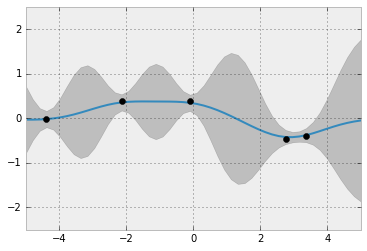

In [35]:
plt.plot(x_test, y_test_mean)
plt.plot(x_obs, y_obs, 'ko')
post_stds = y_test_var.diagonal()
plt.fill_between(x_test, y_test_mean + 2*post_stds, 
                         y_test_mean - 2*post_stds, 
                 color='k', alpha=0.2)
plt.xlim([-5, 5]); plt.ylim([-2.5, 2.5]);

## [Exercise 2.3] The Wiener Process
The Wiener process is defined for $x\ge 0$ and has $f(0)=0$. It has mean zero and a non-startionary covariance function $k(x,x')=\min(x,x')$. If we condition on the Wiener process passing through $f(1)=0$ we obtain a process known as the Brownian Bridge (ot _tied-down_ Wiener process). Show that this process has a covariance $k(x,x')=\min(x,x')-xx'$ for $0\le x,x'\le 1$ and mean $0$.

In [359]:
def wiener_cov(x1,x2):
    return cdist(x1[:,None], x2[:,None], min)

In [360]:
x_test = np.linspace(0, 1)
K_test = wiener_cov(x_test, x_test)
f_prior = np.random.multivariate_normal(np.zeros_like(x_test), K_test, 3)

x_obs = np.array([1]); y_obs = np.array([0.]);
y_test_mean, y_test_var, logmarg = gp_regression(x_obs, y_obs, wiener_cov, sigsq_noise=0.00, x_test=x_test)

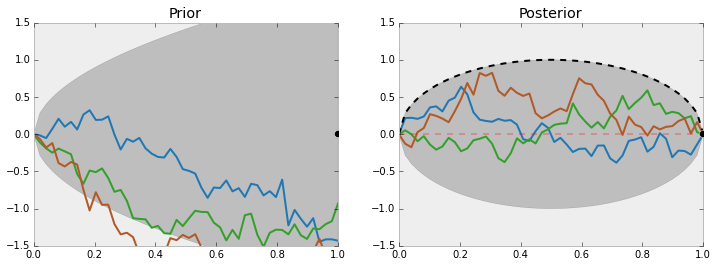

In [361]:
f_conditioned = np.random.multivariate_normal(y_test_mean, y_test_var, 3)

fig, axs = plt.subplots(1,2, figsize=(12,4))

for line in f_prior:
    axs[0].plot(x_test, line)
axs[0].fill_between(x_test, -2*np.sqrt(x_test), 
                             2*np.sqrt(x_test), color='k', alpha=0.2);
axs[0].scatter(x_obs, y_obs, c='k', s=50, zorder=100)
axs[0].set_xlim([-0, 1]); axs[0].set_ylim([-1.5, 1.5]); axs[0].set_title('Prior');

for line in f_conditioned:
    axs[1].plot(x_test, line)

post_stds = np.sqrt(np.maximum(1e-12, y_test_var.diagonal()))
axs[1].fill_between(x_test, y_test_mean + 2*post_stds, 
                            y_test_mean - 2*post_stds, color='k', alpha=0.2)
axs[1].plot(x_test, y_test_mean, c='r', ls='--', alpha=0.25)
axs[1].scatter(x_obs, y_obs, c='k', s=50, zorder=100)
axs[1].set_xlim([-0, 1]); axs[1].set_ylim([-1.5, 1.5]); axs[1].set_title('Posterior');
axs[1].plot(x_test, 2*np.sqrt(x_test - x_test**2), ls='--', color='k');

In [362]:
def brownian_bridge_cov(x1,x2):
    return cdist(x1[:,None], x2[:,None], lambda xi, xj: min(xi,xj)-xi*xj)

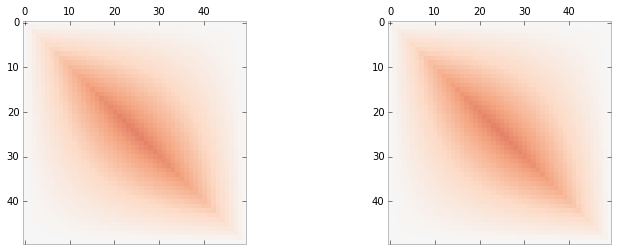

In [363]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].matshow(y_test_var, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
axs[1].matshow(brownian_bridge_cov(x_test,x_test), cmap='RdBu_r', vmin=-0.5, vmax=0.5)

## A Zoo of Covariance Kernels

### Linear Covariance
Results in linear regression

$$y=v(x-c)+b$$

In [355]:
def linear_cov(x1, x2, c=0., sigsq_b=1., sigsq_v=1.):
    k = lambda xi, xj: sigsq_b + sigsq_v*(xi-c)*(xj-c)
    return cdist(x1[:,None], x2[:,None], k)

/Users/Colin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()
/Users/Colin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: covariance is not positive-semidefinite.
/Users/Colin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: covariance is not positive-semidefinite.


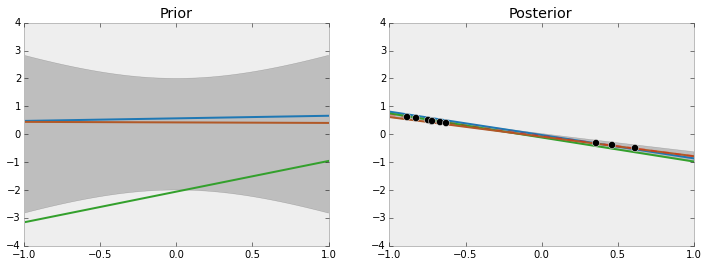

In [356]:
x_test = np.linspace(-1, 1)
K_test = linear_cov(x_test, x_test)
f_prior = np.random.multivariate_normal(np.zeros_like(x_test), K_test, 3)

x_obs = np.random.rand(10)
y_obs = 1. + 1. * x_obs + 0.1*np.random.randn(10)

x_obs = 2.*np.random.rand(10) - 1.
K_obs = linear_cov(x_obs, x_obs)
y_obs = np.random.multivariate_normal(np.zeros_like(x_obs), K_obs)

y_test_mean, y_test_var, logmarg = gp_regression(x_obs, y_obs, linear_cov, sigsq_noise=0.01, x_test=x_test)
f_conditioned = np.random.multivariate_normal(y_test_mean, y_test_var, 3)

fig, axs = plt.subplots(1,2, figsize=(12,4))

for line in f_prior:
    axs[0].plot(x_test, line)

prio_stds = np.sqrt(np.maximum(1e-12, K_test.diagonal()))
axs[0].fill_between(x_test, 0 + 2*prio_stds, 
                            0 - 2*prio_stds, color='k', alpha=0.2)
axs[0].set_xlim([-1, 1]); axs[0].set_ylim([-4,4]); axs[0].set_title('Prior');

for line in f_conditioned:
    axs[1].plot(x_test, line)

post_stds = np.sqrt(np.maximum(1e-12, y_test_var.diagonal()))
axs[1].fill_between(x_test, y_test_mean + 2*post_stds, 
                            y_test_mean - 2*post_stds, color='k', alpha=0.2)
axs[1].plot(x_test, y_test_mean, c='r', ls='--', alpha=0.25)
axs[1].scatter(x_obs, y_obs, c='k', s=50, zorder=100)
axs[1].set_xlim([-1, 1]); axs[1].set_ylim([-4,4]); axs[1].set_title('Posterior');

### Periodic

In [336]:
def periodic_cov(x1, x2, sigsq=1., p=1., l=1.):
    k = lambda xi ,xj: np.exp(-2*np.sin(np.pi*np.abs(xi-xj)/p)**2/l**2)
    return sigsq*cdist(x1[:,None], x2[:,None], k)

/Users/Colin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()
/Users/Colin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: covariance is not positive-semidefinite.


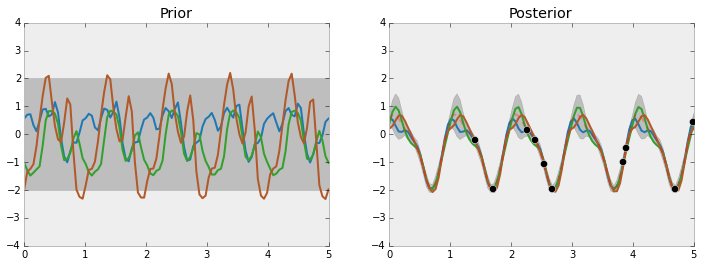

In [343]:
x_test = np.linspace(0, 5, 100)
K_test = periodic_cov(x_test, x_test, l = 0.5)
f_prior = np.random.multivariate_normal(np.zeros_like(x_test), K_test, 3)

x_obs = 5*np.random.rand(10)
K_obs = periodic_cov(x_obs, x_obs)
y_obs = np.random.multivariate_normal(np.zeros_like(x_obs), K_obs)

y_test_mean, y_test_var, logmarg = gp_regression(x_obs, y_obs, periodic_cov, sigsq_noise=0.01, x_test=x_test)
f_conditioned = np.random.multivariate_normal(y_test_mean, y_test_var, 3)

fig, axs = plt.subplots(1,2, figsize=(12,4))

for line in f_prior:
    axs[0].plot(x_test, line)

prio_stds = np.sqrt(np.maximum(1e-12, K_test.diagonal()))
axs[0].fill_between(x_test, 0 + 2*prio_stds, 
                            0 - 2*prio_stds, color='k', alpha=0.2)
axs[0].set_xlim([0, 5]); axs[0].set_ylim([-4,4]); axs[0].set_title('Prior');

for line in f_conditioned:
    axs[1].plot(x_test, line)

post_stds = np.sqrt(np.maximum(1e-12, y_test_var.diagonal()))
axs[1].fill_between(x_test, y_test_mean + 2*post_stds, 
                            y_test_mean - 2*post_stds, color='k', alpha=0.2)
axs[1].plot(x_test, y_test_mean, c='r', ls='--', alpha=0.25)
axs[1].scatter(x_obs, y_obs, c='k', s=50, zorder=100)
axs[1].set_xlim([0, 5]); axs[1].set_ylim([-4,4]); axs[1].set_title('Posterior');

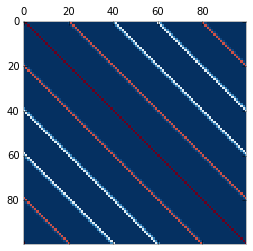

In [342]:
plt.matshow(K_test, cmap='RdBu_r')

### Local Periodic

In [344]:
def loc_periodic_cov(x1, x2, sigsq=1., p=1., l=1.):
    k = lambda xi, xj: (np.exp(-2*np.sin(np.pi*np.abs(xi-xj)/p)**2/l**2)*
                        np.exp(-(xi-xj)**2/(2*l**2)))
    return sigsq*cdist(x1[:,None], x2[:,None], k)

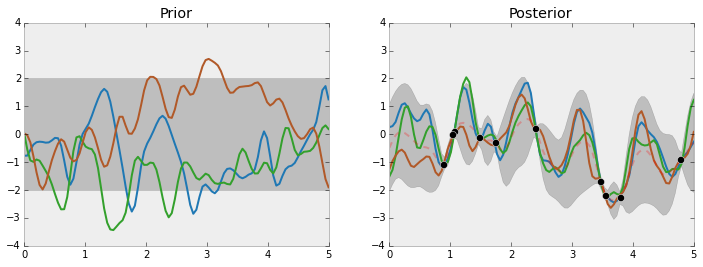

In [345]:
x_test = np.linspace(0, 5, 100)
K_test = loc_periodic_cov(x_test, x_test)
f_prior = np.random.multivariate_normal(np.zeros_like(x_test), K_test, 3)

x_obs = 5*np.random.rand(10)
K_obs = loc_periodic_cov(x_obs, x_obs)
y_obs = np.random.multivariate_normal(np.zeros_like(x_obs), K_obs)

y_test_mean, y_test_var, logmarg = gp_regression(x_obs, y_obs, loc_periodic_cov, sigsq_noise=0.01, x_test=x_test)
f_conditioned = np.random.multivariate_normal(y_test_mean, y_test_var, 3)

fig, axs = plt.subplots(1,2, figsize=(12,4))

for line in f_prior:
    axs[0].plot(x_test, line)

prio_stds = np.sqrt(np.maximum(1e-12, K_test.diagonal()))
axs[0].fill_between(x_test, 0 + 2*prio_stds, 
                            0 - 2*prio_stds, color='k', alpha=0.2)
axs[0].set_xlim([0, 5]); axs[0].set_ylim([-4,4]); axs[0].set_title('Prior');

for line in f_conditioned:
    axs[1].plot(x_test, line)

post_stds = np.sqrt(np.maximum(1e-12, y_test_var.diagonal()))
axs[1].fill_between(x_test, y_test_mean + 2*post_stds, 
                            y_test_mean - 2*post_stds, color='k', alpha=0.2)
axs[1].plot(x_test, y_test_mean, c='r', ls='--', alpha=0.25)
axs[1].scatter(x_obs, y_obs, c='k', s=50, zorder=100)
axs[1].set_xlim([0, 5]); axs[1].set_ylim([-4,4]); axs[1].set_title('Posterior');

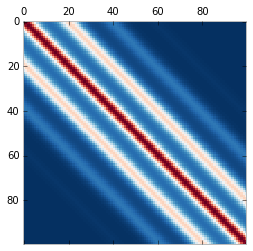

In [274]:
plt.matshow(K_test, cmap='RdBu_r')

### The Matern Covariance

In [346]:
def matern_cov(x1, x2, sigsq=1., p=1., l=1.):
    k = lambda xi, xj: np.exp(-2*np.sin(np.pi*np.abs(xi-xj)/p)**2/l**2)*np.exp(-(xi-xj)**2/(2*l**2))
    return sigsq*cdist(x1[:,None], x1[:,None], k)

## Model Selection and Optimizing Hyperparameters

The covariance kernel is parameterized by several parameters. These are secondary to the primary parameters of interest in function estimation, and so are called _hyperparameters_. As they won't be known a priori, we'll want to find the best covariance hyperparameters for the data. Moreover, there are many covariance kernels to choose from (see above), and we will want a systematic way of deciding which covariance kernel and hyperparameters to use.

$$p(\mathbf{w}|\mathbf{y},X,\mathbf{\theta},\mathcal{H}_i) = \frac{p(\mathbf{y}|X,\mathbf{w}, \mathcal{H}_i)p(\mathbf{w}|\mathbf{\theta},\mathcal{H}_i)}{p(\mathbf{y}|X,\mathbf{\theta},\mathcal{H}_i)}$$

The denominator, called then _marginal likelihood_ (or evidence) is independent of the estimated parameters and is given by
$$p(\mathbf{y}|X,\mathbf{\theta},\mathcal{H}_i)=\int p(\mathbf{y}|X,\mathbf{w}, \mathcal{H}_i)p(\mathbf{w}|\mathbf{\theta},\mathcal{H}_i)d\mathbf{w}.$$

We can similarly express the posterior over the hyperparameters, using the marginal likelihood from above:
$$p(\mathbf{\theta}|\mathbf{y},X,\mathcal{H}_i) = \frac{p(\mathbf{y}|X, \mathbf{\theta},\mathcal{H}_i)p(\mathbf{\theta}|\mathcal{H}_i)}{p(\mathbf{y}|X,\mathcal{H}_i)}$$
again where
$$p(\mathbf{y}|X,\mathcal{H}_i) = \int p(\mathbf{y}|X, \mathbf{\theta},\mathcal{H}_i)p(\mathbf{\theta}|\mathcal{H}_i)d\mathbf{\theta}.$$

The integrals above are typically analytically intractable, with the rare exception of Gaussian process regression models with Gaussian noise (gotta love those Gaussian integrals!). In this case, the parameters we are estimating can be thought of as the (noise-free) function values $\mathbf{f}$ at the observation locations $X$ so we are calculating
$$p(\mathbf{y}|X,\mathbf{f},\mathcal{H}_i)=\int p(\mathbf{y}|X,\mathbf{f}, \mathcal{H}_i)p(\mathbf{f}|\mathbf{\theta},\mathcal{H}_i)d\mathbf{f}.$$

By the definition of a Gaussian Process, we can express the prior $\mathbf{f}|X,\mathbf{\theta},\mathcal{H}_i \sim \mathcal{N}(\mathbf{0},K)$ or
$$\log p(f|X,\mathbf{\theta},\mathcal{H}_i) = -\frac{1}{2}\mathbf{f}^T K^{-1}\mathbf{f} - \frac{1}{2}|K| - \frac{n}{2}\log2\pi$$
and the assumption of Gaussian Noise implies $\mathbf{y}|\mathbf{f}\sim\mathcal(\mathbf{f},\sigma_n^2I)$. All together, this evaluates to (TO PROVE)
$$\log p(\mathbf{y}|X,\mathbf{\theta}) = \frac{1}{2}\mathbf{y}^TK_y^{-1}\mathbf{y} - \frac{1}{2}\log|K_y| - \frac{n}{2}\log2\pi,$$
where $K_y = K_f + \sigma_n^2I$ is the covariance matrix for the noisy targets $\mathbf{y}$ (and $K_f$ is the covariance matrix for the noise-free latent $\mathbf{f}$ prescribed by model $\mathcal{H}_i$ and parameterized by $\mathbf{\theta}$).

We can set the hyperparameters by maximizing the marginal likelihood. We first obtain the partial derivatives of the marginal likelihood with respect to the hyperparameters (TO PROVE)
$$\begin{align}\frac{\partial}{\partial \theta_j} \log p(\mathbf{y}|X,\mathbf{\theta}) &= \frac{1}{2}\mathbf{y}^TK^{-1}\frac{\partial K}{\partial \theta_j}K^{-1}\mathbf{y} - \frac{1}{2}\textrm{tr}(K^{-1}\frac{\partial K}{\partial \theta_j})\\
&=\frac{1}{2}\textrm{tr}\left((\mathbf{\alpha\alpha}^T - K^{-1})\frac{\partial K}{\partial \theta_j}\right)\end{align}$$
where $\mathbf{\alpha} = K^{-1}\mathbf{y}$. The complexity of computing the marginal likelihood is dominated by inverting the $K$ matrix, which requires $\mathcal{O}(n^3)$ time. Once $K^{-1}$ is known, the computation of the derivatives requires only $\mathcal{O}(n^2)$ time per hyperparameter.

-4.28355288791
[-2.22124884  0.91395696 -4.33195014]
8.61203158851e-08


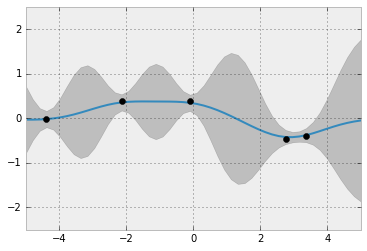

In [265]:
reload(gp)
reload(ks)

mysq_exp_cov = ks.SquareExponential()
mygpr = gp.GPR(mysq_exp_cov)
y_test_mean, y_test_var = mygpr.fit_transform(y_obs, x_obs, 0.1, x_test)

plt.plot(x_test, y_test_mean)
plt.plot(x_obs, y_obs, 'ko')
post_stds = y_test_var.diagonal()
plt.fill_between(x_test, y_test_mean + 2*post_stds, 
                         y_test_mean - 2*post_stds, 
                 color='k', alpha=0.2)
plt.xlim([-5, 5]); plt.ylim([-2.5, 2.5]);

print mygpr.logmarg([1., 1., 0.01])
print mygpr.grad_logmarg([1., 1., 0.01])

from scipy.optimize import check_grad
print check_grad(mygpr.logmarg, mygpr.grad_logmarg, [1.,1., 0.01])

## 2D Example - COMING

In [308]:
from mpl_toolkits.mplot3d import Axes3D

x1_test = x2_test = np.linspace(-5,5,20)
X1_test, X2_test = np.meshgrid(x1_test, x2_test)
x_test = np.array(np.meshgrid(x1_test, x2_test)).reshape(2,20**2)
K_test = sq_exp_cov(x_test, x_test)
f_prior = np.random.multivariate_normal(np.zeros(x_test.shape[1]), K_test)

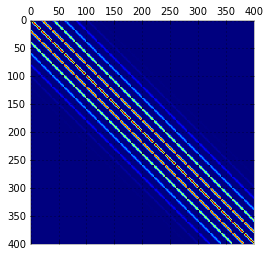

In [261]:
plt.matshow(K_test)

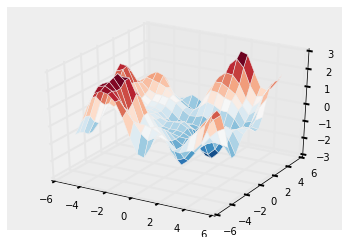

In [249]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X1_test, X2_test, f_prior.reshape(20,20), cmap='RdBu_r', rstride=1, cstride=1, shade=False)

In [311]:
x_obs = 10*np.random.rand(2, 20) - 5
K_obs = sq_exp_cov(x_obs, x_obs)
y_obs = np.random.multivariate_normal(np.zeros(x_obs.shape[1]), K_obs)

y_test_mean, y_test_var, logmarg = gp_regression(x_obs, y_obs, sq_exp_cov, sigsq_noise=0.01, x_test=x_test)

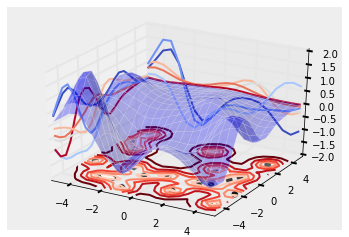

In [312]:
import matplotlib.cm as cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y, Z = X1_test, X2_test, y_test_mean.reshape(20,20)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.3)
cset = ax.contour(X, Y, np.sqrt(y_test_var.diagonal()).reshape(20,20), 
                  zdir='z', offset=-2, cmap=cm.Reds)
cset = ax.contour(X, Y, Z, zdir='x', offset=-5, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=5, cmap=cm.coolwarm)

one_mask = np.ones_like(y_obs)
ax.scatter(x_obs[0,:], x_obs[1,:], -2*one_mask, c='k', s=50, depthshade=True)

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-2, 2)

plt.show()

##Feature Space - COMING

##Experimental Design - COMING

In [252]:
reload(gp)

<module 'gpr' from '../code/gpr.py'>

In [253]:
mysq_exp_cov = ks.SquareExponential()
mygpr = gp.GPR(mysq_exp_cov)
y_test_mean, y_test_var = mygpr.fit_transform(y_obs, x_obs, 0.1, x_test)